<a href="https://colab.research.google.com/github/RohanBolle/BigCrunch/blob/main/Big_crunch%3F.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import scipy as sp
from sympy import lambdify
import cmath
from scipy.integrate import odeint
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

In [ ]:
G0 = 1
H_0 = 1 / 13.8  # Hubble constant
c = 3e9
Omega_0_m = 5  # normalized mass density
omega_r = 10e-4
omega_lambda = 0
omega_k = 1-omega_r-omega_lambda-Omega_0_m
omega_0 = omega_lambda + omega_r + Omega_0_m

# Time settings
t_i = 0.001
t_f = 10
y_i = 0.01
r_vals = np.linspace(0.1, 10, 1000)

In [ ]:
np.sum([omega_r, omega_lambda, Omega_0_m])

np.float64(5.001)

/tmp/ipython-input-116-3083123174.py:2: RuntimeWarning: invalid value encountered in sqrt
  sol_ori = solve_ivp(lambda t, r: r*H_0*np.sqrt(Omega_0_m/(r**3) + (omega_k)/(r**2) + omega_r/(r**4) + omega_lambda), [t_i, t_f], [y_i], t_eval=np.linspace(t_i, t_f, 1000), dense_output = False, method='RK45', rtol = 1e-3)


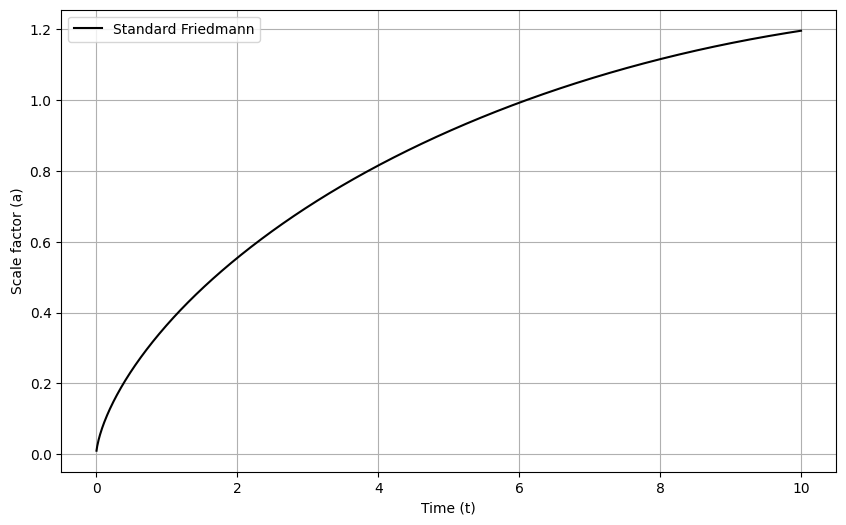

In [ ]:
# Original Friedmann
sol_ori = solve_ivp(lambda t, r: r*H_0*np.sqrt(Omega_0_m/(r**3) + (omega_k)/(r**2) + omega_r/(r**4) + omega_lambda), [t_i, t_f], [y_i], t_eval=np.linspace(t_i, t_f, 1000), dense_output = False, method='RK45', rtol = 1e-3)

plt.figure(figsize=(10, 6))
plt.plot(sol_ori.t, sol_ori.y[0],  "-", color ='black', label ='Standard Friedmann')
plt.xlabel("Time (t)")
plt.ylabel("Scale factor (a)")
plt.legend()
plt.grid()
plt.show()


In [ ]:
amax = sol_ori.y[0][-1]

In [ ]:
from scipy.optimize import root

def expression_under_sqrt(r):
  # The function expects a single value for r
  if isinstance(r, (list, np.ndarray)):
    r = r[0] # Take the first element if it's an array

  return Omega_0_m/(r**3) + omega_k/(r**2) + omega_r/(r**4) + omega_lambda

# We need to provide an initial guess for the root.
# Looking at the plot we made earlier, there seems to be a root around r=1.
initial_guess = 1.0

# Find the root
sol = root(expression_under_sqrt, initial_guess)

if sol.success:
  root_value = sol.x[0]
  print(f"The expression under the square root is approximately zero at r = {root_value:.4f}")
  # Based on the plot, for r greater than this value, the expression is negative.
  print(f"The square root turns negative for r values approximately greater than {root_value:.4f}")
else:
  print("Root finding failed.")


The expression under the square root is approximately zero at r = 1.2499
The square root turns negative for r values approximately greater than 1.2499


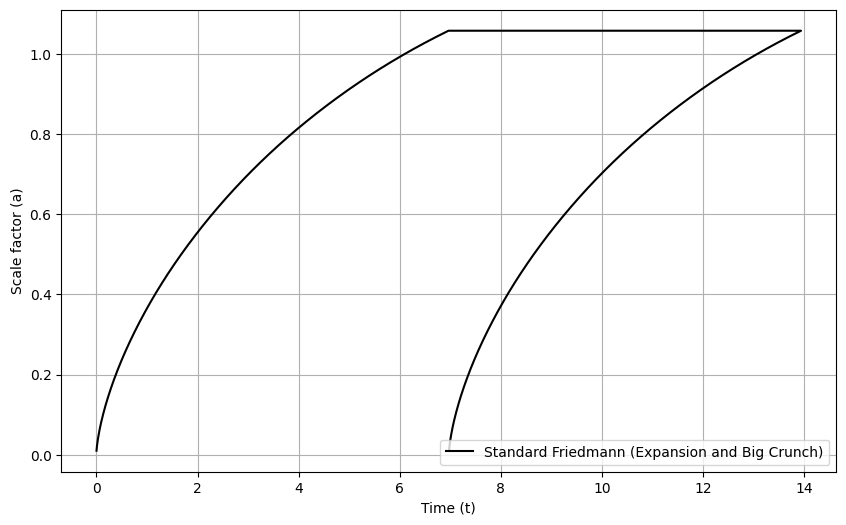

In [ ]:
# This is a conceptual example and might need adjustments
# depending on how precisely you want to handle the time axis

# Assuming sol_ori.t and sol_ori.y[0] contain the expansion data up to amax
# Find the index where the scale factor is close to amax (root_value)
root_value = 1.059
amax_index = np.argmin(np.abs(sol_ori.y[0] - root_value))

# Get the time at amax
t_at_amax = sol_ori.t[amax_index]

# Reverse the time and scale factor data from amax to the beginning
# We'll create new time values that go forward in time from t_at_amax
# The scale factor values will be the reversed values from the expansion

# Time for the Big Crunch phase (relative to t_at_amax)
big_crunch_relative_time = sol_ori.t[:amax_index][::-1] - sol_ori.t[0]

# Scale factor for the Big Crunch phase
big_crunch_scale_factor = sol_ori.y[0][:amax_index][::-1]

# Total time for the combined plot
combined_t = np.concatenate((sol_ori.t[:amax_index], t_at_amax + big_crunch_relative_time))

# Total scale factor for the combined plot
combined_y = np.concatenate((sol_ori.y[0][:amax_index], big_crunch_scale_factor))


plt.figure(figsize=(10, 6))
plt.plot(combined_t, combined_y,  "-", color ='black', label ='Standard Friedmann (Expansion and Big Crunch)')
plt.xlabel("Time (t)")
plt.ylabel("Scale factor (a)")
plt.legend()
plt.grid()
plt.show()

CHATGPT SOLUTION

ΣΩ_i = 5.0001   →   Ω_k = -4.0001
Turn-around at a_max = 1.250
Lifetime of the universe:  t_crunch = 1.944  (in 1/H0 units)


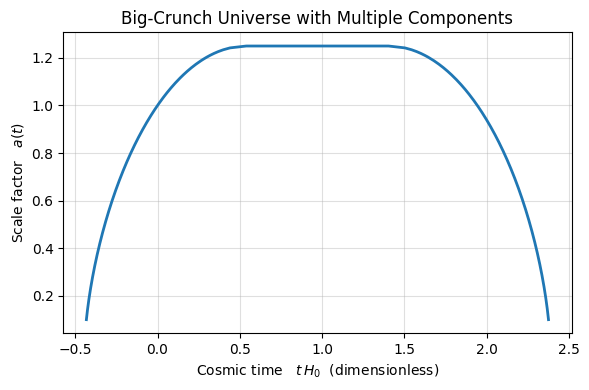

In [ ]:
"""
Multi-component Friedmann solver that produces a Big Crunch

Conventions
-----------
c = 1,  a0 = 1  (present-day scale factor)
Time is reported in units of 1/H0  (e.g. 1/H0 ≈ 14 Gyr for H0 = 70 km/s/Mpc)

Components implemented
----------------------
Radiation        :  w = 1/3   (ρ ∝ a⁻⁴)
Matter           :  w = 0     (ρ ∝ a⁻³)
Cosmic strings   :  w = –1/3  (ρ ∝ a⁻²)
Domain walls     :  w = –2/3  (ρ ∝ a⁻¹)
Stiff matter     :  w = 1     (ρ ∝ a⁻⁶)
Dark energy (Λ)  :  w = –1    (ρ ∝ const.; ΩΛ may be *negative*)
Spatial curvature:  encoded through Ω_k = 1 – ΣΩ_i   (positive k ⇒ Ω_k < 0)

A closed (Ω_k < 0) matter-dominated model *or* a model with negative Λ will
recollapse.  By default we combine both so the turnaround happens quickly
enough to see on a small time axis.
"""
import numpy as np
from scipy.integrate import quad
import matplotlib.pyplot as plt

# -----------------------------------------------------------------------------
# 1. Specify the energy-density parameters Ω_i at a = 1
#    ***Adjust these to taste, but keep  ΣΩ_i  > 1  OR  choose ΩΛ < 0
# -----------------------------------------------------------------------------
params = {
    "radiation"      : 1.0e-4,   # Ω_r [0.10]
    "matter"         : 5.00,   # Ω_m [1.20]
    "cosmic_strings" : 0.00,   # Ω_cs[0.05]
    "domain_walls"   : 0.00,   # Ω_dw[0.05]
    "stiff_matter"   : 0.00,   # Ω_sm[0.0]
    "dark_energy"    : 0.00   # Ω_Λ [-0.50](NEGATIVE ⇒ acts like an attractive force)
}

# Barotropic indices  w  for the components
w_map = {
    "radiation"      : 1/3,
    "matter"         : 0.0,
    "cosmic_strings" : -1/3,
    "domain_walls"   : -2/3,
    "stiff_matter"   : 1.0,
    "dark_energy"    : -1.0
}

# Present-day curvature parameter Ω_k
Omega_total = sum(params.values())
Omega_k = 1.0 - Omega_total        # closed if Ω_k < 0
print(f"ΣΩ_i = {Omega_total}   →   Ω_k = {Omega_k}")

# -------------------------------------------------------------------------
# 2. Helper: E(a) = H(a) / H0  (dimensionless Hubble parameter)
# -------------------------------------------------------------------------
def E2(a: float) -> float:
    """Dimensionless Hubble parameter squared, E(a)^2."""
    term_sum = Omega_k * a**-2                     # curvature
    for name, Ω in params.items():
        w = w_map[name]
        term_sum += Ω * a**(-3 * (1 + w))
    return term_sum

# -------------------------------------------------------------------------
# 3. Find the turnaround point  a_max  where  E^2 = 0  (expansion stops)
# -------------------------------------------------------------------------
from mpmath import findroot
a_max = float(findroot(lambda x: E2(x), 1.0))      # initial guess 2 ≳ 1
print(f"Turn-around at a_max = {a_max:.3f}")

# -------------------------------------------------------------------------
# 4. Cosmic time t(a) by quadrature  t = ∫ da / [a H0 E(a)]
# -------------------------------------------------------------------------
H0 = 1.0   # we work in units where H0 = 1; multiply by 1/H0 later if needed

def dt_da(a):           # integrand  dt/da  for outward (+) branch
    return 1.0 / (a * np.sqrt(E2(a)))

# Time from today (a=1) to the turnaround
t_half, _ = quad(dt_da, 0.1, a_max, epsabs=1e-9, epsrel=1e-9, limit=200)
t_total = 2.0 * t_half
print(f"Lifetime of the universe:  t_crunch = {t_total:.3f}  (in 1/H0 units)")

# -------------------------------------------------------------------------
# 5. Generate a(t) for plotting: integrate out, then mirror back
# -------------------------------------------------------------------------
a_grid = np.geomspace(0.1, a_max, 400)
t_grid = np.array([quad(dt_da, 1.0, a)[0] for a in a_grid])
# Contracting branch: reverse arrays and shift time by t_half
a_full = np.concatenate([a_grid, a_grid[::-1]])
t_full = np.concatenate([t_grid,  t_half + (t_half - t_grid[::-1])])

# -------------------------------------------------------------------------
# 6. Plot
# -------------------------------------------------------------------------
plt.figure(figsize=(6, 4))
plt.plot(t_full, a_full, lw=2)
plt.xlabel(r"Cosmic time   $t\,H_0$  (dimensionless)")
plt.ylabel(r"Scale factor   $a(t)$")
plt.title("Big-Crunch Universe with Multiple Components")
plt.grid(True, alpha=0.4)
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy.optimize import root_scalar

G_0 = 1.0
H_0 = 1.0
c = 1.0

In [ ]:
# ------------------------STANDARD BIG CRUNCH------------------------

def E1(a):
  term_a = Omega_k / a**2
  term_b = (omega_0) / (a**3 * G_0)
  term_c = (omega_0**2 * H_0**2) / (G_0 * a**6 * 2 * c**2)
  term_d = (omega_0) / (G_0 * c**3 * a**3)
  return term_a + term_b + term_c + term_d

a_vals_1 = np.geomspace(0.1, 20, 1000)
e1_vals = np.array([E1(a) for a in a_vals_1])
sign_changes = np.where(np.diff(np.signbit(e1_vals)))[0]

if len(sign_changes) > 0:
  idx = sign_changes[0]
  bracket = [a_vals_1[idx], a_vals_1[idx + 1]]
  result = root_scalar(lambda x: E1(x), bracket=bracket, method='brentq')
  a_max1 = result.root

  def dt1_da(a):
    return 1.0 / (a * np.sqrt(E1(a)))

  # Integrate time from early a ~ 1e-5 instead of a = 1
  t1_half, _ = quad(dt1_da, 1e-5, a_max1, epsabs=1e-9, epsrel=1e-9, limit=200)
  a1_grid = np.geomspace(1e-5, a_max1, 400)
  t1_grid = np.array([quad(dt1_da, 1e-5, a)[0] for a in a1_grid])

  a1_full = np.concatenate([a1_grid, a1_grid[::-1]])
  t1_full = np.concatenate([t1_grid, t1_half + (t1_half - t1_grid[::-1])])
  crunch_results_pos.append((t1_full, a1_full))

\begin{equation} 1+ αln(a) \end{equation}

/tmp/ipython-input-138-738995772.py:74: RuntimeWarning: invalid value encountered in sqrt
  def dt_da(a): return 1.0 / (a * np.sqrt(E2(a)))
/tmp/ipython-input-138-738995772.py:77: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  t_half, _ = quad(dt_da, 1e-5, a_max, epsabs=1e-9, epsrel=1e-9, limit=200)
/tmp/ipython-input-138-738995772.py:79: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  t_grid = np.array([quad(dt_da, 1e-5, a)[0] for a in a_grid])
/tmp/ipython-input-138-738995772.py:79: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  t_grid = np.array([quad(dt_da, 1e-5, a)[0] for a in a_grid])


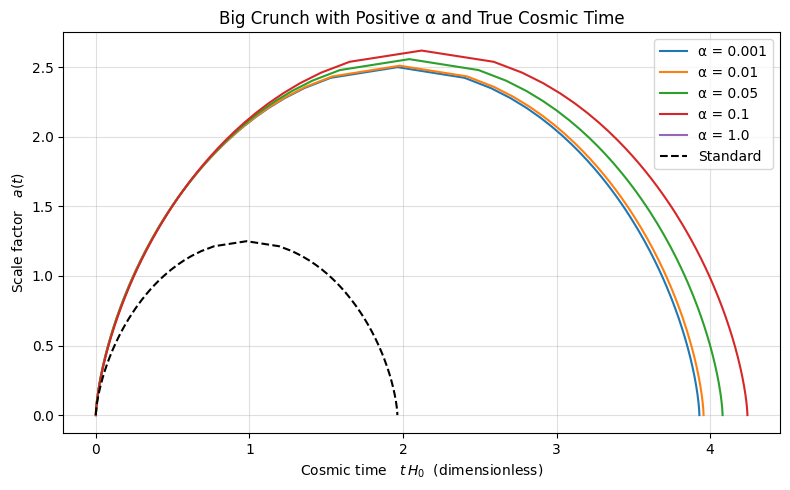

In [ ]:
def E1(a):
  term_a = Omega_k / a**2
  term_b = (omega_0) / (a**3 * G_0)
  term_c = (omega_0**2 * H_0**2) / (G_0 * a**6 * 2 * c**2)
  term_d = (omega_0) / (G_0 * c**3 * a**3)
  return term_a + term_b + term_c + term_d

a_vals_1 = np.geomspace(0.1, 20, 1000)
e1_vals = np.array([E1(a) for a in a_vals_1])
sign_changes = np.where(np.diff(np.signbit(e1_vals)))[0]

if len(sign_changes) > 0:
  idx = sign_changes[0]
  bracket = [a_vals_1[idx], a_vals_1[idx + 1]]
  result = root_scalar(lambda x: E1(x), bracket=bracket, method='brentq')
  a_max1 = result.root

  def dt1_da(a):
    return 1.0 / (a * np.sqrt(E1(a)))

  # Integrate time from early a ~ 1e-5 instead of a = 1
  t1_half, _ = quad(dt1_da, 1e-5, a_max1, epsabs=1e-9, epsrel=1e-9, limit=200)
  a1_grid = np.geomspace(1e-5, a_max1, 400)
  t1_grid = np.array([quad(dt1_da, 1e-5, a)[0] for a in a1_grid])

  a1_full = np.concatenate([a1_grid, a1_grid[::-1]])
  t1_full = np.concatenate([t1_grid, t1_half + (t1_half - t1_grid[::-1])])
  crunch_results_pos.append((t1_full, a1_full))

# CHATGPT's FIXED CODE
def func_0(a, alpha):
    a = float(a)
    return G_0 * alpha * np.log(a) + 2 * G_0

def func_1(a, alpha):
    a = float(a)
    term1 = G_0**2 * (alpha * np.log(a) + 1)**2
    bracket = (G_0**2 * alpha**2 * np.log(a)) / (2 * a**2) - (G_0**2 * alpha**2) / (4 * a**2) + (G_0**2 * alpha) / (2 * a**2)
    term2 = a**2 * bracket
    return term1 - term2

def func_2(a, alpha):
    a = float(a)
    term1 = G_0**2 * (alpha * np.log(a) + 1)**2
    bracket = (G_0**2 * alpha**2 * np.log(a)) / (3 * a**3) - (G_0**2 * alpha**2) / (9 * a**3) + (G_0**2 * alpha) / (3 * a**3)
    term2 = 2 * a**3 * bracket
    return term1 - term2

# -----------------------------x---------------------------------

alpha_values = [0.001, 0.01, 0.05, 0.1, 1.0]
omega_0 = 5.0
Omega_k = 1.0 - omega_0
crunch_results_pos = []

for alpha in alpha_values:
    def E2(a):
        term0 = Omega_k / a**2
        term1 = (omega_0 * func_0(a, alpha)) / (a**3 * G_0)
        term2 = (omega_0**2 * H_0**2 * func_1(a, alpha)**2) / (G_0 * a**6 * 2 * c**2)
        term3 = (omega_0 * func_2(a, alpha)**2) / (G_0 * c**3 * a**3)
        return term0 + term1 + term2 + term3

    a_vals = np.geomspace(0.1, 20, 1000)
    e2_vals = np.array([E2(a) for a in a_vals])
    sign_changes = np.where(np.diff(np.signbit(e2_vals)))[0]

    if len(sign_changes) > 0:
        idx = sign_changes[0]
        bracket = [a_vals[idx], a_vals[idx + 1]]
        result = root_scalar(lambda x: E2(x), bracket=bracket, method='brentq')
        a_max = result.root

        def dt_da(a): return 1.0 / (a * np.sqrt(E2(a)))

        # Integrate time from early a ~ 1e-5 instead of a = 1
        t_half, _ = quad(dt_da, 1e-5, a_max, epsabs=1e-9, epsrel=1e-9, limit=200)
        a_grid = np.geomspace(1e-5, a_max, 400)
        t_grid = np.array([quad(dt_da, 1e-5, a)[0] for a in a_grid])
        a_full = np.concatenate([a_grid, a_grid[::-1]])
        t_full = np.concatenate([t_grid, t_half + (t_half - t_grid[::-1])])

        crunch_results_pos.append((alpha, t_full, a_full))

# Plot corrected cosmic time
plt.figure(figsize=(8, 5))
for alpha, t_vals, a_vals in crunch_results_pos:
    plt.plot(t_vals, a_vals, label=f"α = {alpha}")
plt.plot(t1_full, a1_full, 'k--', label="Standard")
plt.xlabel(r"Cosmic time   $t\,H_0$  (dimensionless)")
plt.ylabel(r"Scale factor   $a(t)$")
plt.title("Big Crunch with Positive α and True Cosmic Time")
plt.legend()
plt.grid(True, alpha=0.4)
plt.tight_layout()
plt.show()



\begin{equation} G_{0}a^{B} \end{equation}

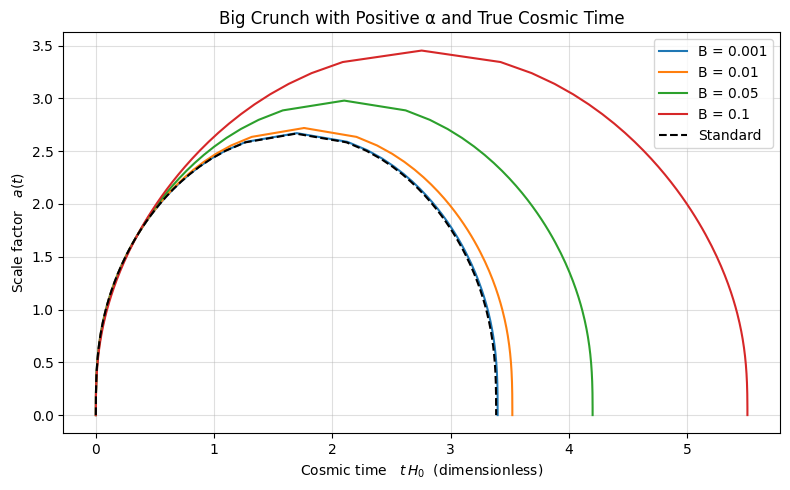

In [ ]:
#FIXED CODE
def func1_0(r, B):
    if np.isclose(B, 1):
        return -B * G_0 * r * np.log(r) + G_0 * r**B
    else:
        return -B * G_0 * r * (r**B / (B * r - r)) + G_0 * r**B

def func1_1(r, B):
    if np.isclose(B, 1):
        return B * G_0**2 * r**2 * np.log(r) + G_0**2 * r**(2*B)
    else:
        return B * G_0**2 * r**2 * (r**(2*B) / (2 * B * r**2 - 2 * r**2)) + G_0**2 * r**(2*B)

def func1_2(r, B):
    if np.isclose(B, 1.5):
        return 2 * B * G_0**2 * r**3 * np.log(r) + G_0**2 * r**(2*B)
    else:
        return 2 * B * G_0**2 * r**3 * (r**(2*B) / (2 * B * r**3 - 3 * r**3)) + G_0**2 * r**(2*B)

# -----------------------------x---------------------------------

B_values = [0.001, 0.01, 0.05, 0.1, 1.0]
omega_0 = 5.0
Omega_k = 1.0 - omega_0
crunch_results_pos = []

for B in B_values:
    def E2(a):
        term0 = Omega_k / a**2
        term1 = (omega_0 * func1_0(a, B)) / (a**3 * G_0)
        term2 = (omega_0**2 * H_0**2 * func1_1(a, B)**2) / (G_0 * a**6 * 2 * c**2)
        term3 = (omega_0 * func1_2(a, B)**2) / (G_0 * c**3 * a**3)
        return term0 + term1 + term2 + term3

    a_vals = np.geomspace(0.1, 20, 1000)
    e2_vals = np.array([E2(a) for a in a_vals])
    sign_changes = np.where(np.diff(np.signbit(e2_vals)))[0]

    if len(sign_changes) > 0:
        idx = sign_changes[0]
        bracket = [a_vals[idx], a_vals[idx + 1]]
        result = root_scalar(lambda x: E2(x), bracket=bracket, method='brentq')
        a_max = result.root

        def dt_da(a): return 1.0 / (a * np.sqrt(E2(a)))

        # Integrate time from early a ~ 1e-5 instead of a = 1
        t_half, _ = quad(dt_da, 1e-5, a_max, epsabs=1e-9, epsrel=1e-9, limit=200)
        a_grid = np.geomspace(1e-5, a_max, 400)
        t_grid = np.array([quad(dt_da, 1e-5, a)[0] for a in a_grid])
        a_full = np.concatenate([a_grid, a_grid[::-1]])
        t_full = np.concatenate([t_grid, t_half + (t_half - t_grid[::-1])])

        crunch_results_pos.append((B, t_full, a_full))

# Plot corrected cosmic time
plt.figure(figsize=(8, 5))
for B, t_vals, a_vals in crunch_results_pos:
    plt.plot(t_vals, a_vals, label=f"B = {B}")
plt.plot(t1_full, a1_full, 'k--', label="Standard")
plt.xlabel(r"Cosmic time   $t\,H_0$  (dimensionless)")
plt.ylabel(r"Scale factor   $a(t)$")
plt.title("Big Crunch with Positive α and True Cosmic Time")
plt.legend()
plt.grid(True, alpha=0.4)
plt.tight_layout()
plt.show()

CHAT GPT - CYCLOID SOLUTION

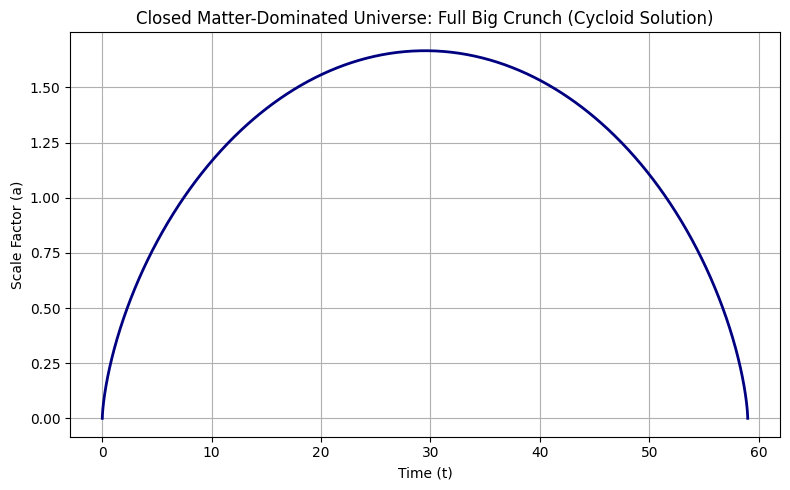

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Input parameters
H0 = 1 / 13.8
Omega_m = 2.5  # >1 ensures closed universe
Omega_k = 1 - Omega_m

# Cycloid constants from the Friedmann eq
A = Omega_m / (2 * (Omega_m - 1))
B = A / (H0 * np.sqrt(Omega_m - 1))

# Parametric parameter θ from 0 to 2π
theta = np.linspace(0, 2 * np.pi, 1000)

# Scale factor and time parametrically
a = A * (1 - np.cos(theta))
t = B * (theta - np.sin(theta))

plt.figure(figsize=(8, 5))
plt.plot(t, a, color='navy', lw=2)
plt.xlabel("Time (t)")
plt.ylabel("Scale Factor (a)")
plt.title("Closed Matter-Dominated Universe: Full Big Crunch (Cycloid Solution)")
plt.grid(True)
plt.tight_layout()
plt.show()


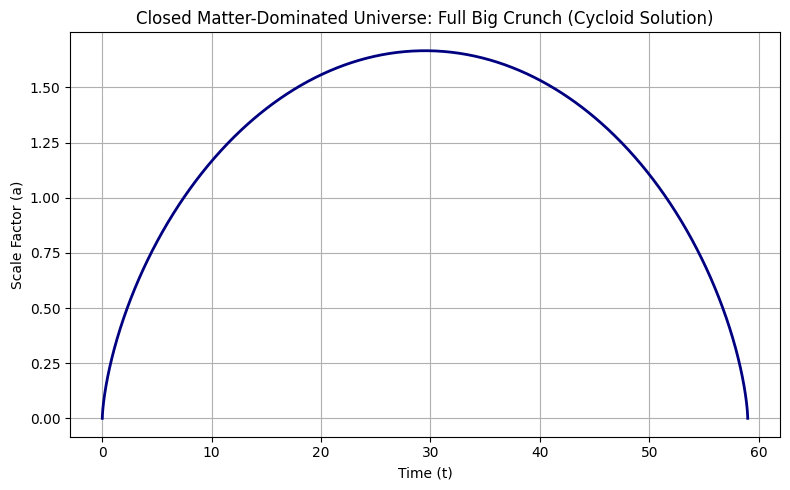

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Input parameters
H0 = 1 / 13.8
Omega_m = 2.5
Omega_k = 1 - Omega_m


A = -Omega_m/(2*Omega_k)
B = Omega_m/(2*H0*(-Omega_k)**(3/2))


theta = np.linspace(0, 2 * np.pi, 1000)


a = A * (1 - np.cos(theta))
t = B * (theta - np.sin(theta))

plt.figure(figsize=(8, 5))
plt.plot(t, a, color='navy', lw=2)
plt.xlabel("Time (t)")
plt.ylabel("Scale Factor (a)")
plt.title("Closed Matter-Dominated Universe: Full Big Crunch (Cycloid Solution)")
plt.grid(True)
plt.tight_layout()
plt.show()


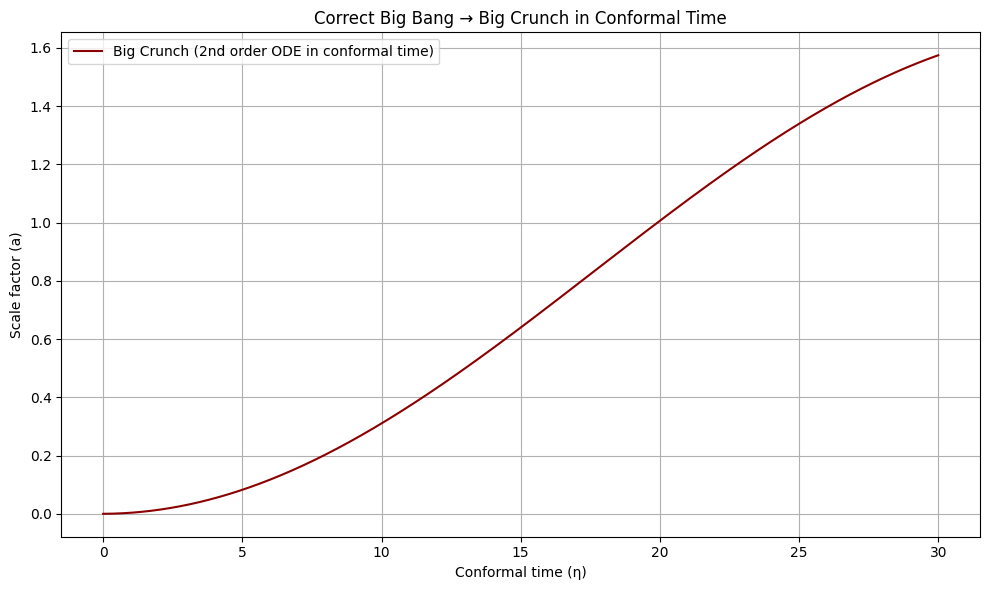

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# Parameters
H0 = 1 / 13.8
Omega_m = 2.5
Omega_k = 1 - Omega_m  # < 0 for closed universe

# Dynamical system in conformal time
def friedmann_second_order(eta, y):
    a, v = y  # y[0] = a, y[1] = da/dη
    dv_deta = 0.5 * H0**2 * (Omega_m + 2 * Omega_k * a)
    return [v, dv_deta]

# Initial conditions
a0 = 1e-5
v0 = H0 * np.sqrt(Omega_m * a0 + Omega_k * a0**2)
y0 = [a0, v0]

# Solve for full conformal time range
eta_span = [0, 30]  # You can adjust upper limit to capture full cycle
sol = solve_ivp(friedmann_second_order, eta_span, y0, t_eval = np.linspace(0,30, 2000), rtol=1e-8)

a_vals = sol.y[0]
eta_vals = sol.t

# Trim after Big Crunch (a→0 again)
valid_idx = np.where(a_vals >= 0)[0]
a_vals = a_vals[valid_idx]
eta_vals = eta_vals[valid_idx]

# Plot
plt.figure(figsize=(10, 6))
plt.plot(eta_vals, a_vals, label="Big Crunch (2nd order ODE in conformal time)", color='darkred')
plt.xlabel("Conformal time (η)")
plt.ylabel("Scale factor (a)")
plt.title("Correct Big Bang → Big Crunch in Conformal Time")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


A_MAX

In [ ]:
#New G_star functions from the latest image -------- a = alpha

def func0(r, a):  # G_star
    return G_0 * a + G_0 * (a * np.log(r) + 1)

def func1(r, a):  # G1_star
    term1 = G_0**2 * (a * np.log(r) + 1)**2
    bracket = (G_0**2 * a**2 * np.log(r)) / (2 * r**2) - (G_0**2 * a**2) / (4 * r**2) + (G_0**2 * a) / (2 * r**2)
    term2 = r**2 * bracket
    return term1 - term2

def func2(r, a):  # G2_star
    term1 = G_0**2 * (a * np.log(r) + 1)**2
    bracket = (G_0**2 * a**2 * np.log(r)) / (3 * r**3) - (G_0**2 * a**2) / (9 * r**3) + (G_0**2 * a) / (3 * r**3)
    term2 = 2 * r**3 * bracket
    return term1 - term2

/tmp/ipython-input-125-2565840452.py:4: RuntimeWarning: invalid value encountered in log
  return G_0 * alpha * np.log(a) + 2 * G_0
/tmp/ipython-input-125-2565840452.py:8: RuntimeWarning: invalid value encountered in log
  term1 = G_0**2 * (alpha * np.log(a) + 1)**2
/tmp/ipython-input-125-2565840452.py:9: RuntimeWarning: invalid value encountered in log
  bracket = (G_0**2 * alpha**2 * np.log(a)) / (2 * a**2) - (G_0**2 * alpha**2) / (4 * a**2) + (G_0**2 * alpha) / (2 * a**2)
/tmp/ipython-input-125-2565840452.py:15: RuntimeWarning: invalid value encountered in log
  term1 = G_0**2 * (alpha * np.log(a) + 1)**2
/tmp/ipython-input-125-2565840452.py:16: RuntimeWarning: invalid value encountered in log
  bracket = (G_0**2 * alpha**2 * np.log(a)) / (3 * a**3) - (G_0**2 * alpha**2) / (9 * a**3) + (G_0**2 * alpha) / (3 * a**3)


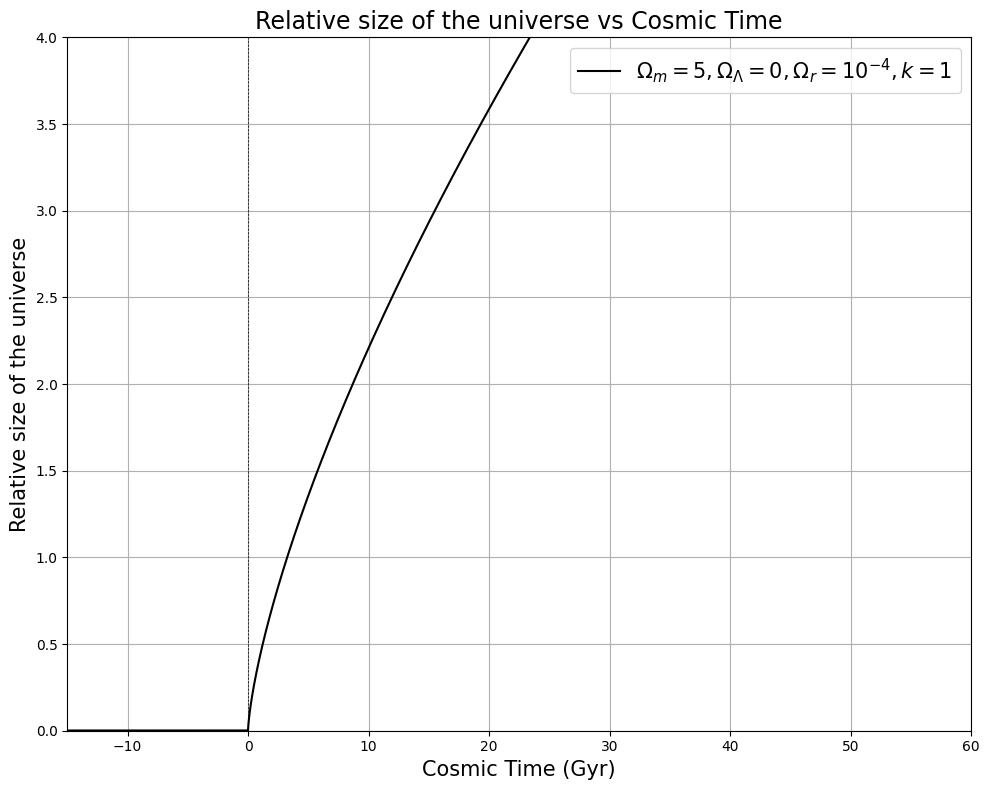

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# plt.rcParams['text.usetex'] = True

# Constants
H0 = 67400 / (3.09 * 10**22) * (3600 * 24 * 365 * 10**9)  # Hubble constant in Gyr^-1
alpha = 0.3

# Function for the differential system
def friedmann_system(t, y, Omega_m, Omega_r, Omega_l, Omega_k):
    a, _ = y
    sqrt_term = ((omega_0 * func_0(a, alpha)) / (a**3 * G0) +
        (omega_0**2 * H0**2 * func_1(a, alpha)**2) / (G0 * a**6 * 2 * c**2) +
        (omega_0 * func_2(a, alpha)**2) / (G0 * c**3 * a**3))
    if sqrt_term < 0:
        return 0  # Prevent division by zero or negative scale factors
    return a * H0 * np.sqrt(sqrt_term)

# Event function to stop the integration when `a` reaches 0
def stop_event_a_zero(t, y):
    a, _ = y
    return a - 1e-8  # Stop when a approaches 0

# Event function to stop the integration when `a` reaches 4
def stop_event_a_limit(t, y):
    a, _ = y
    return 10 - a  # Stop when a approaches 10

# Mark both events as terminal
stop_event_a_zero.terminal = True
stop_event_a_zero.direction = -1  # Stop when decreasing to 0
stop_event_a_limit.terminal = True
stop_event_a_limit.direction = 1  # Stop when increasing to 4

# Initial conditions
a0 = 0.01
a_dot0_template = lambda Omega_m, Omega_r, Omega_l, Omega_k: H0 * (
    Omega_m / a0 + Omega_r / a0**2 + Omega_k + Omega_l * a0**2
)**0.5

scenarios = [
    # {"Omega_m": 0.3, "Omega_r": 1e-4, "Omega_l": 0.0, "color": "blue", "label": r"$\Omega_m=0.3, \Omega_\Lambda=0, \Omega_r=10^{-4}, k=-1$"},
    # {"Omega_m": 0.3, "Omega_r": 1e-4, "Omega_l": 0.7, "color": "red", "label": r"$\Omega_m=0.3, \Omega_\Lambda=0.7, \Omega_r=10^{-4}, \Omega_k \simeq 0$"},
    {"Omega_m": 5.0, "Omega_r": 0, "Omega_l": 0.0, "color": "black", "label": r"$\Omega_m=5, \Omega_\Lambda=0, \Omega_r=10^{-4}, k=1$"},
    # {"Omega_m": 1.0, "Omega_r": 1e-4, "Omega_l": 0.0, "color": "magenta", "label": r"$\Omega_m=1, \Omega_\Lambda=0, \Omega_r=10^{-4}, k=1$"},
]

# Solve and plot
plt.figure(figsize=(10, 8))  # Square plot

for scenario in scenarios:
    Omega_m = scenario["Omega_m"]
    Omega_r = scenario["Omega_r"]
    Omega_l = scenario["Omega_l"]
    Omega_k = 1 - Omega_m - Omega_r - Omega_l  # Compute curvature parameter

    # Compute initial a_dot
    # a_dot0 = a_dot0_template(Omega_m, Omega_r, Omega_l, Omega_k)
    # initial_conditions = [a0, a_dot0]

    initial_conditions = [a0, 10]
    # Solve backwards and forwards with increased resolution
    solution_backward = solve_ivp(
        lambda t, y: friedmann_system(t, y, Omega_m, Omega_r, Omega_l, Omega_k),
        [0, -15],
        initial_conditions,
        events=[stop_event_a_zero],
        dense_output=False,
        max_step=0.01  # Small step size for higher resolution
    )
    solution_forward = solve_ivp(
        lambda t, y: friedmann_system(t, y, Omega_m, Omega_r, Omega_l, Omega_k),
        [0, 30],
        initial_conditions,
        events=[stop_event_a_limit],
        dense_output=False,
        max_step=0.01  # Small step size for higher resolution
    )

    # Combine results
    t = np.concatenate((solution_backward.t[::-1], solution_forward.t))
    a = np.concatenate((solution_backward.y[0][::-1], solution_forward.y[0]))

    # Plot
    plt.plot(t, a, color=scenario["color"], label=scenario["label"])

# Finalize plot
plt.axhline(0, color="black", linewidth=0.5, linestyle="--")
plt.axvline(0, color="black", linewidth=0.5, linestyle="--")
plt.grid(True)
plt.xlabel("Cosmic Time (Gyr)", fontsize=15)  # Increase font size for x-axis
plt.ylabel("Relative size of the universe", fontsize=15)  # Increase font size for y-axis
plt.title("Relative size of the universe vs Cosmic Time", fontsize=17)  # Increase font size for title
plt.xlim(-15, 60)
plt.ylim(0, 4)
plt.legend(fontsize=15)  # Increase font size for legend
plt.tight_layout()
# plt.savefig("friedmann_solving.pdf")
plt.show()

time 0.0, scale factror: [1.e-05], sqrt term:[-1.07394028e+16]
time 1e-06, scale factror: [1.e-05], sqrt term:[-1.07394028e+16]
time 2e-07, scale factror: [1.e-05], sqrt term:[-1.07394028e+16]
time 3e-07, scale factror: [1.e-05], sqrt term:[-1.07394028e+16]
time 8e-07, scale factror: [1.e-05], sqrt term:[-1.07394028e+16]
time 8.888888888888888e-07, scale factror: [1.e-05], sqrt term:[-1.07394028e+16]
time 1e-06, scale factror: [1.e-05], sqrt term:[-1.07394028e+16]
time 1e-06, scale factror: [1.e-05], sqrt term:[-1.07394028e+16]
time 3e-06, scale factror: [1.e-05], sqrt term:[-1.07394028e+16]
time 4e-06, scale factror: [1.e-05], sqrt term:[-1.07394028e+16]
time 9e-06, scale factror: [1.e-05], sqrt term:[-1.07394028e+16]
time 9.888888888888889e-06, scale factror: [1.e-05], sqrt term:[-1.07394028e+16]
time 1.1e-05, scale factror: [1.e-05], sqrt term:[-1.07394028e+16]
time 1.1e-05, scale factror: [1.e-05], sqrt term:[-1.07394028e+16]
time 3.0999999999999995e-05, scale factror: [1.e-05], sq

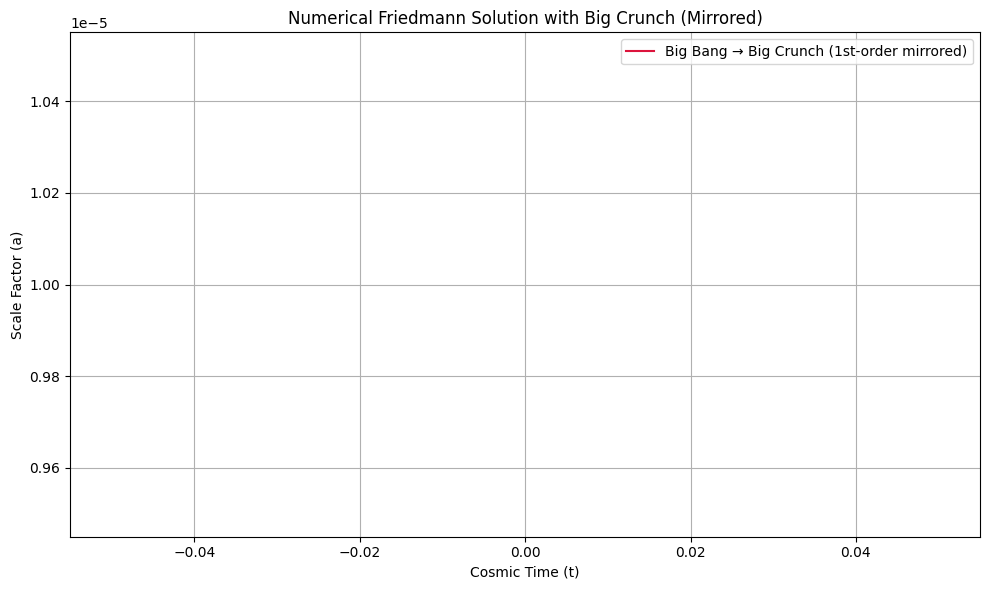

1
Time points from solver: [0.000000e+00 1.000000e-06 1.100000e-05 1.110000e-04 1.111000e-03
 1.111100e-02 2.111100e-02 3.111100e-02 4.111100e-02 5.111100e-02
 6.111100e-02 7.111100e-02 8.111100e-02 9.111100e-02 1.011110e-01
 1.111110e-01 1.211110e-01 1.311110e-01 1.411110e-01 1.511110e-01
 1.611110e-01 1.711110e-01 1.811110e-01 1.911110e-01 2.011110e-01
 2.111110e-01 2.211110e-01 2.311110e-01 2.411110e-01 2.511110e-01
 2.611110e-01 2.711110e-01 2.811110e-01 2.911110e-01 3.011110e-01
 3.111110e-01 3.211110e-01 3.311110e-01 3.411110e-01 3.511110e-01
 3.611110e-01 3.711110e-01 3.811110e-01 3.911110e-01 4.011110e-01
 4.111110e-01 4.211110e-01 4.311110e-01 4.411110e-01 4.511110e-01
 4.611110e-01 4.711110e-01 4.811110e-01 4.911110e-01 5.011110e-01
 5.111110e-01 5.211110e-01 5.311110e-01 5.411110e-01 5.511110e-01
 5.611110e-01 5.711110e-01 5.811110e-01 5.911110e-01 6.011110e-01
 6.111110e-01 6.211110e-01 6.311110e-01 6.411110e-01 6.511110e-01
 6.611110e-01 6.711110e-01 6.811110e-01 6.911110e

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# Constants
H0 = 1 / 13.8
G0 = 1
c = 3e8
omega_0 = 5

# Dummy functions (replace with your real func_0, func_1, func_2)
def func0(r, a):  # G_star
    return G_0 * a + G_0 * (a * np.log(r) + 1)

def func1(r, a):  # G1_star
    term1 = G_0**2 * (a * np.log(r) + 1)**2
    bracket = (G_0**2 * a**2 * np.log(r)) / (2 * r**2) - (G_0**2 * a**2) / (4 * r**2) + (G_0**2 * a) / (2 * r**2)
    term2 = r**2 * bracket
    return term1 - term2

def func2(r, a):  # G2_star
    term1 = G_0**2 * (a * np.log(r) + 1)**2
    bracket = (G_0**2 * a**2 * np.log(r)) / (3 * r**3) - (G_0**2 * a**2) / (9 * r**3) + (G_0**2 * a) / (3 * r**3)
    term2 = 2 * r**3 * bracket
    return term1 - term2

alpha = 0.3

# Friedmann ODE (first-order)
def friedmann_first_order(t, a):
    sqrt_term = (
        (omega_0 * func0(a, alpha)) / (a**3 * G0) +
        (omega_0**2 * H0**2 * func1(a, alpha)**2) / (G0 * a**6 * 2 * c**2) +
        (omega_0 * func2(a, alpha)**2) / (G0 * c**3 * a**3))
    print(f"time {t}, scale factror: {a}, sqrt term:{sqrt_term}")
    if sqrt_term < 0:
        return 0
    return a * H0 * np.sqrt(sqrt_term)

# def friedmann_first_order(t, a):
#     sqrt_term = (
#         (omega_0 * func0(a, alpha)) / (a**3 * G0) +
#         (omega_0**2 * H0**2 * func1(a, alpha)**2) / (G0 * a**6 * 2 * c**2) +
#         (omega_0 * func2(a, alpha)**2) / (G0 * c**3 * a**3))
#     return a * H0 * np.sqrt(sqrt_term)

# Solve forward from Big Bang to a_max
a0 = 1e-5
t_span = (0, 5)
sol = solve_ivp(friedmann_first_order, t_span, [a0], max_step=0.01, rtol=1e-8)

# Extract values up to turnaround
a_expanding = sol.y[0]
t_expanding = sol.t
i_max = np.argmax(a_expanding)
a_half = a_expanding[:i_max+1]
t_half = t_expanding[:i_max+1]

# Mirror collapse
a_full = np.concatenate([a_half, a_half[::-1][1:]])
t_full = np.concatenate([t_half, 2 * t_half[-1] - t_half[::-1][1:]])

# Plot
plt.figure(figsize=(10, 6))
plt.plot(t_full, a_full, label="Big Bang → Big Crunch (1st-order mirrored)", color="crimson")
plt.xlabel("Cosmic Time (t)")
plt.ylabel("Scale Factor (a)")
plt.title("Numerical Friedmann Solution with Big Crunch (Mirrored)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

print(len(a_half))

print("Time points from solver:", sol.t)
print("Scale factor values from solver:", sol.y[0])